In [205]:
import comet_ml
from comet_ml import Experiment

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parametrize

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.datasets import Planetoid, KarateClub


from utils import FeatureSmoothnessLoss, SparseLoss, plot_adjacency_matrix
from models import ASGL

In [219]:
a=0.75

A = torch.rand((30, 30))#*0.5 + 0.25
A.requires_grad = True
A_before = A.clone()

loss_fn = SparseLoss(a)

A_evolution = []

for _ in range(2000):
    loss = loss_fn(A)
    A.grad = None
    loss.backward()
    # Apply parametrizations
    A.data = A.data.triu() + A.data.triu(1).transpose(-1, -2)
    # No self-loops (at least for now)
    A.data = A.data.fill_diagonal_(0)
    A.data -= 1e-1*A.grad
    A_evolution.append(A.clone().data.view(-1))
A_evolution = torch.stack(A_evolution, dim=0)

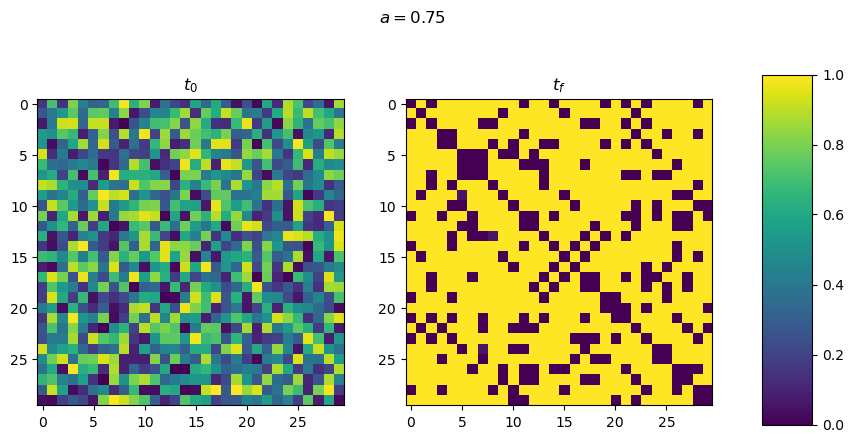

In [220]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(A_before.detach(), vmin=0, vmax=1)
im = ax2.imshow(A.detach(), vmin=0, vmax=1)
ax1.set_title(r"$t_0$")
ax2.set_title(r"$t_f$")
fig.suptitle(r"$a=$"+ str(a))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(f"images/adj_{a}.png", dpi=300)
plt.show()
